# DeepLab - Image Segmentation - Xception65

## Import libraries

In [1]:
from DeepLabModel import DeepLabModel
from glob import glob
from google.colab.patches import cv2_imshow
from imageio import mimread
from io import BytesIO
from matplotlib import  gridspec
from matplotlib.style import use
from PIL import Image
from six.moves import urllib
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from tqdm import tqdm

import cv2
import IPython
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import random
#import tarfile
import tempfile
import tensorflow as tf

use('seaborn')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.9.2


In [2]:
def create_colormap():
    """
    Retunr:
        NumPy array with a colormap to visualize the segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [120, 155,  42],
        [152, 251, 152],
        [ 93, 165, 227],
        [220,  20,  60],
        [255,   0,   0],
        [ 34,  34, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap

In [3]:
def label_to_color_image(label):
    """
    Parameters:
        label: 2D array that stores the segmentation label.

    Return:
        Segmentation map: a 2D array with float values. The array element is an indexed color by correspondent element in the input label. 
        In other words, the return is an image like the original image, but the pixels will be segmented with the network prediction.
    """
    
    # Error if the input label doesn't have two dimensions.
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_colormap()

    # Error if label index is larger than the maximum index of colormap list.
    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

## Label names, class identifiers and colors associated with it.

In [4]:
LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

print(f'Number of labels: {len(LABEL_NAMES)}')

Number of labels: 20


In [5]:
# Class indentifiers. 
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1) 
# Colors associated with class identifiers.
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

for label, color in zip(FULL_LABEL_MAP, FULL_COLOR_MAP):
  print(label, color)

[0] [[128  64 128]]
[1] [[244  35 232]]
[2] [[70 70 70]]
[3] [[102 102 156]]
[4] [[190 153 153]]
[5] [[153 153 153]]
[6] [[250 170  30]]
[7] [[220 220   0]]
[8] [[120 155  42]]
[9] [[152 251 152]]
[10] [[ 93 165 227]]
[11] [[220  20  60]]
[12] [[255   0   0]]
[13] [[ 34  34 142]]
[14] [[ 0  0 70]]
[15] [[  0  60 100]]
[16] [[  0  80 100]]
[17] [[  0   0 230]]
[18] [[119  11  32]]
[19] [[0 0 0]]


In [6]:
MODEL_URL = 'http://download.tensorflow.org/models/deeplabv3_cityscapes_train_2018_02_06.tar.gz'

In [7]:
TARBALL_NAME = 'deeplab_model.tar.gz'
model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

In [8]:
download_path = os.path.join(model_dir, TARBALL_NAME)
download_path

'/tmp/tmpbq8hi66y/deeplab_model.tar.gz'

In [9]:
urllib.request.urlretrieve(MODEL_URL, download_path)

('/tmp/tmpbq8hi66y/deeplab_model.tar.gz',
 <http.client.HTTPMessage at 0x7f747231a250>)

## Create the model

In [10]:
model = DeepLabModel(download_path)

## Model test

### Load the image test

In [11]:
TEST_IMAGE_PATH = '/content/image_segmentation_example.jpg'
original_image = Image.open(TEST_IMAGE_PATH)

### Result

In [12]:
segmentation_map = model.run(original_image)

### Segmentation visualization

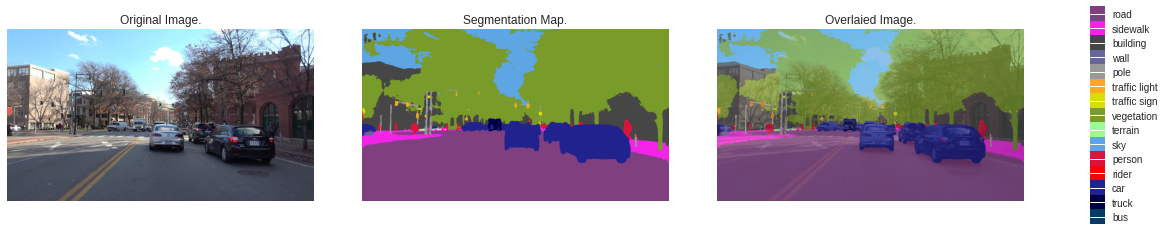

In [13]:
seg_image = label_to_color_image(segmentation_map).astype(np.uint8)

plt.figure(figsize=(20, 4))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(original_image)
plt.axis('off')
plt.title('Original Image.')

plt.subplot(grid_spec[1])
plt.imshow(seg_image)
plt.axis('off')
plt.title('Segmentation Map.')

plt.subplot(grid_spec[2])
plt.imshow(original_image)
plt.imshow(seg_image, alpha=0.7)
plt.axis('off')
plt.title('Overlaied Image.') 

unique_labels = np.unique(segmentation_map)
ax = plt.subplot(grid_spec[3])
plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
ax.yaxis.tick_right()
plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
plt.xticks([], [])
ax.tick_params(width=0.0)
plt.grid('off')

plt.show()